
## TESSCut Overlay with DSS
This notebook is an example of accessing and displaying a TESS FFI Cutout using the MAST TessCut service built into astroquery.  It uses astroquery to retrieve the related objects from the Tess Input Catalog (TIC). We then grab the related DSS image and overlay the TIC objects and the TESSCut image altogether.   

This notebook uses several base packages but requires the following additional packages:
- astropy
- astroquery > 0.3.9
- k2flix
- ipython > 7.2
- ipywidgets > 7.4.2
- reproject

In [1]:
# import some base packages we need
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
import os
import glob
import numpy as np
import requests
import matplotlib as plt

# Getting a Custom TESS Cutout Target Pixel File
The first step is to get the Target Pixel File.  There are two options.  The easier option is to use the **Astroquery** python package.  The second method is using the TESS MAST AstroCut API service directly. 


In [2]:
# select a target and cutout size in pixels
ra, dec = 66.582618, -67.806508
#ra, dec = 92.37794, -66.5167
target = '{0}, {1}'.format(ra, dec)
x = 11
y = 11

# set local file path to current working directory
path = os.path.abspath(os.path.curdir)

### Use Astroquery to retrieve the TESSCut image

In [3]:
import astroquery
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import astropy.units as u

# create a sky coordinate object
cutout_coords = SkyCoord(ra, dec, unit="deg")
    
# download the files and get the list of local paths
try:
    table = Tesscut.download_cutouts(cutout_coords, size=x, path=path)
except Exception as e:
    print('Error: Could not download cutouts: {0}'.format(e))
else:
    print(table)
    files = table['Local Path']

Inflating...
                                                  Local Path                                                 
-------------------------------------------------------------------------------------------------------------
/Users/smullally/Python_Code/MASTTools/tess_notebooks/tess-s0001-4-1_66.582618_-67.806508_11x11_astrocut.fits
/Users/smullally/Python_Code/MASTTools/tess_notebooks/tess-s0002-4-2_66.582618_-67.806508_11x11_astrocut.fits


### Open a Target Pixel File 
We'll be using Kepler's **k2flix** Python package to open and access the file

In [4]:
import k2flix
filename = os.path.join(path, files[0])
tpf = k2flix.TargetPixelFile(filename)

# get number of pixels in flux array 
n_pix = tpf.flux().shape[0]

# compute field of view in degrees
res = 21.0 * (u.arcsec/u.pixel)
area = res * (n_pix * u.pixel)
d = area.to(u.degree)
fov = d.value 

# compute the wcs of the image
wcs = WCS(tpf.hdulist['APERTURE'].header)

# print some info
print('filename', tpf.filename)
print('Target TPF', target)
print('Field of View [degrees]', fov)
print('Number pixels', tpf.flux().shape)

filename /Users/smullally/Python_Code/MASTTools/tess_notebooks/tess-s0001-4-1_66.582618_-67.806508_11x11_astrocut.fits
Target TPF 66.582618, -67.806508
Field of View [degrees] 0.06416666666666666
Number pixels (11, 11)


### Create and display a GIF of the custom TPF

In [5]:
# create the gif
gif = tpf.filename.replace('.fits', '.gif')
if not os.path.exists(gif):
    tpf.save_movie(gif, show_flags=True)

  3%|▎         | 3/107 [00:00<00:04, 24.89it/s]

Creating /Users/smullally/Python_Code/MASTTools/tess_notebooks/tess-s0001-4-1_66.582618_-67.806508_11x11_astrocut.gif


100%|██████████| 107/107 [00:02<00:00, 37.69it/s]


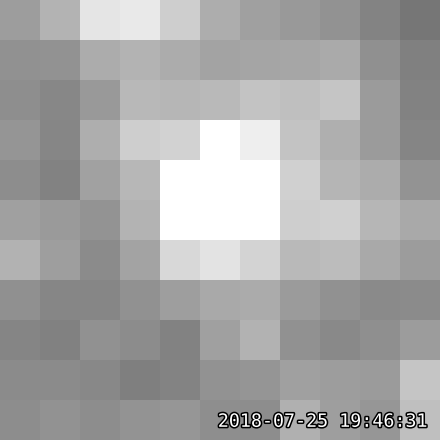

In [6]:
# display the gif
if not os.path.exists(gif):
    print("No gif found. Cannot display gif of time-series.")

from IPython.display import Image
Image(gif, embed=True)

### Find targets within TPF FOV in TESS Input Catalog

In [7]:
from astroquery.mast import Catalogs
catalogData = Catalogs.query_region(target, radius=fov/2., catalog="Tic")
print('n_targets', len(catalogData))

n_targets 18


### Plot static TPF image and overlay TIC catalog

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# get RA and Dec coords of catalog data
tic_ra = catalogData['ra']
tic_dec = catalogData['dec']

# get pixel coordinates of RA and Dec 
coords = wcs.all_world2pix(list(zip(tic_ra, tic_dec)),0)
xc = [c[0] for c in coords]
yc = [c[1] for c in coords]

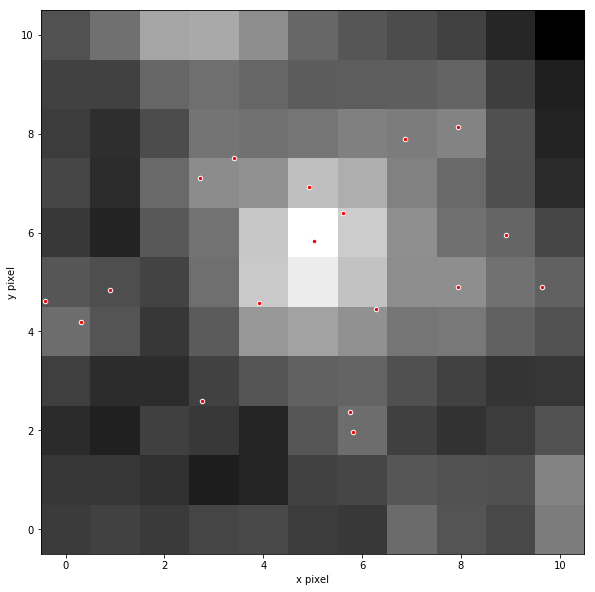

In [9]:
from astropy.visualization import simple_norm

# get first frame of flux from TPF
data = tpf.hdulist['PIXELS'].data["FLUX"][0,:,:]

# use log image normalization
norm = simple_norm(data, 'log')

# plot with wcs or not
use_wcs = False

# plot image and overlay TIC points
ax = plt.subplot(projection=wcs if use_wcs else None)
ax.imshow(data, origin='lower', norm=norm, cmap='gray')
ax.scatter(xc, yc, s=20, facecolor='red', edgecolor='white')

ax.figure.set_size_inches((10,10))

# deal with axes
if use_wcs:
    xax = ax.coords[0]
    yax = ax.coords[1]
    xax.set_ticks(spacing=1.*u.arcmin)
    yax.set_ticks(spacing=0.5 * u.arcmin)
    xax.set_axislabel('Right Ascension')
    yax.set_axislabel('Declination')
else:
    ax.set_xlabel('x pixel')
    ax.set_ylabel('y pixel')


## Retrieve the DSS image of the region
To overlay the TESSCut image against the DSS image, we need to query the STScI DSS Cutout Image service.  First we define a custom function to perform call.  

In [10]:
url = "https://archive.stsci.edu/cgi-bin/dss_search"
plateDict = {"red": "2r", 
             "blue": "2b", 
             "ukred": "poss2ukstu_red", 
             "ukblue": "poss2ukstu_blue"}

def getdss(ra, dec, plate="red", height=None, width=None, 
           filename=None, directory=None):

    """Extract DSS image at position and write a FITS file
    
    ra, dec are J2000 coordinates in degrees
    plate can be "red", "blue", "ukred", or "ukblue"
    height and width are in arcmin, default = 7.0.  Image is square if only one is specified.
    filename specifies name for output file (default="dss_{plate}_{ra}_{dec}.fits")
    directory is location for output file (default is current directory)
    
    Returns the name of the file that was written
    """

    # set defaults for height & width
    if height is None:
        if width is not None:
            height = width
        else:
            height = 7.0
            width = 7.0
    elif width is None:
        width = height

    try:
        vplate = plateDict[plate]
    except KeyError:
        raise ValueError("Illegal plate value '{}'\nShould be one of {}".format(
            plate,', '.join(plateDict.keys())))

    # construct filename
    if filename is None:
        filename = "dss_{}_{:.6f}_{:.6f}.fits".format(plate,ra,dec)
    if directory:
        filename = os.path.join(directory, filename)

    params={"r": ra,
            "d": dec,
            "v": vplate,
            "e": "J2000",
            "h": height,
            "w": width,
            "f":"fits",
            "c":"none",
            "s": "yes"}
    r = requests.get(url, params=params)
    # read and format the output
    value = r.content
    if not r.content.startswith(b"SIMPLE  ="):
        raise ValueError("No FITS file returned for {}".format(filename))
    fhout = open(filename, "wb")
    fhout.write(r.content)
    fhout.close()
    return filename

In [11]:
# compute the pixel area in arcmin
arcmin = area.to(u.arcmin).value

# retrieve the DSS file
filename = getdss(ra, dec, height=arcmin, width=arcmin, directory=path)
print('DSS Image:', filename)

DSS Image: /Users/smullally/Python_Code/MASTTools/tess_notebooks/dss_red_66.582618_-67.806508.fits


Let's display the DSS image and overlay the TIC catalog objects as a sanity check.

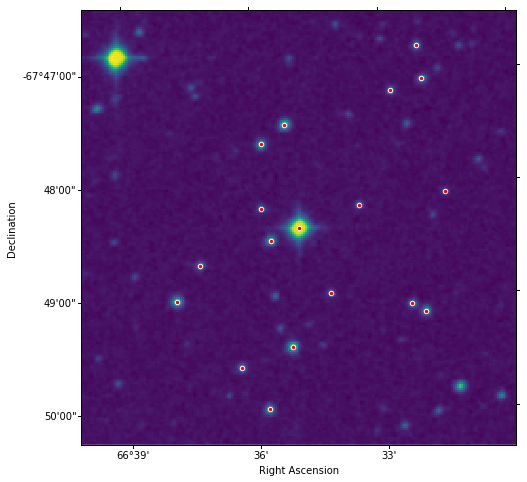

In [12]:
import matplotlib.pyplot as plt
dss = fits.open(filename)

# get the data and WCS for the DSS image
dss_data = dss[0].data
dss_wcs = WCS(dss[0].header)

# display the DSS image and overlay the TIC objects
ax = plt.subplot(projection=dss_wcs)
ax.imshow(dss_data, origin='lower')
ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.figure.set_size_inches((8,8))
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

### Overlay the TessCut Image
To overlay the TESS Cutout against the DSS, we need to reproject the WCS of the TESS cutout onto the WCS of the DSS image.  We can use the [reproject](https://reproject.readthedocs.io/en/stable/index.html) package. Once reprojected, we can properly overly the DSS and TESSCut images.  We can add a slider for the opacity of the overlay using ipywidgets. 

In [29]:
# reproject the tesscut onto dss
from reproject import reproject_interp
reproj_tesscut, footprint = reproject_interp((data, wcs,), dss_wcs, shape_out=dss_data.shape, order='nearest-neighbor')

In [30]:
# create the function to overlay dss + tesscut + tic catalog
def create_plot(data, array, alpha, norm, wcs, ra, dec):
    ax = plt.subplot(projection=wcs)
    ax.figure.set_size_inches((8,8))
    ax.imshow(data, origin='lower')
    ax.imshow(array, origin='lower', alpha=alpha, norm=norm, cmap='gray')
    ax.scatter(ra, dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

In [31]:
from ipywidgets import interact, interactive, fixed, interact_manual

# create an interactive ipywidget plot for the opacity of tesscut
interactive_plot = interactive(create_plot, data=fixed(dss_data), array=fixed(reproj_tesscut), 
                               alpha=(0.0,1.0), norm=fixed(norm), wcs=fixed(dss_wcs), 
                               ra=fixed(tic_ra), dec=fixed(tic_dec))
# display the plot
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0), Output(layout=Layout(height='500px…